# Investigation of planarity of agglomerative clusters

In [1]:
import numpy as np
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

In [2]:
ground_truth = np.load('../data/synthetics_31.npy')
X_syn = np.concatenate(ground_truth, axis = 0)

In [3]:
X_lan = loadmat('../data/landers.mat')['xyz_mat']

In [4]:
def get_capacity_clusters(X: np.array, 
                          min_sz_cluster: int = 4, 
                          min_n_merges: int = 4
                          )->np.array:
    '''
    Get the cluster assignment with the largest number of valid clusters based on ward linkage.
    Iteratively cuts the tree from the bottom until the number of valid clusters does not increase anymore.
    
    Parameters
    -----------
    X: np.array
        The data to compute the cluster assignment for as an array of size (n_samples x n_dimensions)
    
    min_sz_cluster: int
        The threshold on the cluster size for a cluster to be considered valid, default = 4

    min_n_merges: int
        The number of cluster merging steps that can be skipped by the algorithm, default = 4


    Returns
    --------
    capacity_labels: np.array
        The cluster labels as an array of length n_samples
    '''

    min_n_merges = max(min_sz_cluster, min_n_merges)

    link_tree = ward(X)

    capacity = 0
    capacity_labels = np.zeros(len(X))
    prev = [0,0]

    for n_branch in range(1,len(link_tree)):

        # get cluster labels and determine the cluster sizes
        labels = fcluster(link_tree, link_tree[len(link_tree)-n_branch, 2], "distance")-1
        _ , counts = np.unique(labels, return_counts = True)
        
        n_clusters = sum(counts >= min_sz_cluster)

        # check whether capacity has improved
        if n_clusters >= capacity:
            capacity = n_clusters
            capacity_labels = labels
        
        # stop when the number of clusters drops
        elif n_clusters < prev[0] and n_clusters < prev[1]:
            break

        prev.pop()
        prev.insert(n_clusters, 0)

    return capacity_labels

In [5]:
def planarity_score(X: np.ndarray):

    if X.shape[1] != 3:
        raise ValueError(f'Data must be 3-dimensional, was {X.shape[1]}-dimensional')
    
    if X.shape[0] < 3:
        return 1
    
    # get the perc of variance explained by smallest principal component
    pca = PCA(n_components = 3, random_state=71)
    score = pca.fit(X).explained_variance_ratio_[2]

    return 1-score

In [6]:
def cluster_metrics(X: np.ndarray,
                    labels: np.ndarray):

    plan_score = []
    clust_sz = []

    for i in np.unique(labels):

        s = sum(labels == i)

        if s >= 4:

            clust_sz.append(s)
            plan_score.append(planarity_score(X[labels == i])) 

    return np.array(plan_score), np.array(clust_sz)

In [7]:
def get_heatmap_data(x_dec: np.ndarray, y: np.ndarray, n_bins: int):

    _, bins = np.histogram(x_dec, bins = n_bins)
    x = np.digitize(x_dec, bins, right=True)

    data = np.zeros((int(np.max(y)+1), len(bins)))

    for y_i in np.unique(y):
        
        msk = y == y_i 
        vals, cts = np.unique(x[msk], return_counts = True)

        data[y_i, vals] = cts

    return data, bins

In [25]:
min_sz = 15

labels_syn = get_capacity_clusters(X_syn, min_sz_cluster = min_sz)
labels_lan = get_capacity_clusters(X_lan, min_sz_cluster = min_sz)

sc_syn, sz_syn = cluster_metrics(X_syn, labels_syn)
sc_lan, sz_lan = cluster_metrics(X_lan, labels_lan)

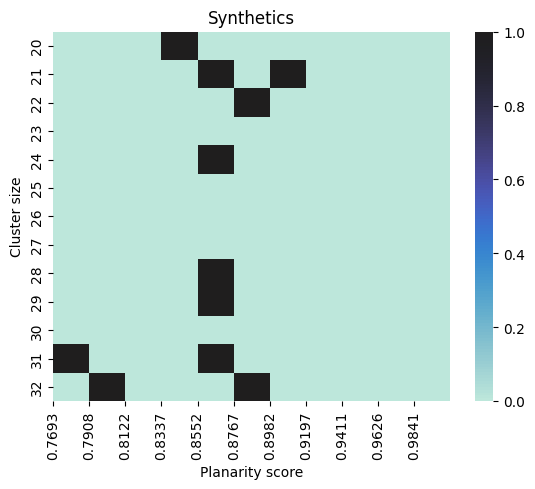

In [ ]:
dat, bins = get_heatmap_data(np.array(sc_syn), np.array(sz_syn), 10)
dat = dat[min_sz:]

plt.title('Synthetics')
ylabs = np.arange(max(np.min(sz_syn), min_sz), np.max(sz_syn)+1)

sns.heatmap(dat, center=np.max(dat), yticklabels=ylabs)
plt.xticks(range(dat.shape[1]), np.round(bins, 4), rotation=90)
plt.ylabel('Cluster size')
plt.xlabel('Planarity score')
plt.show()

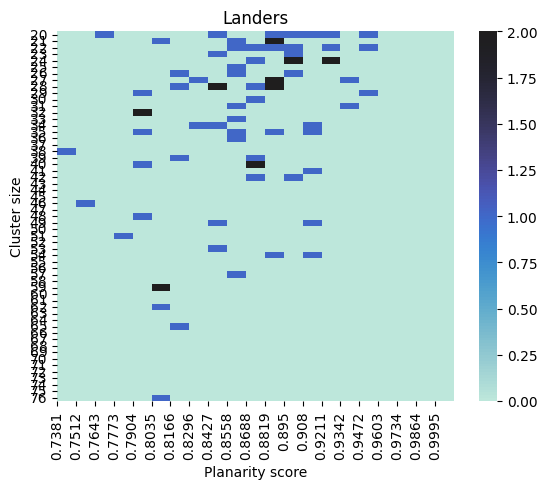

In [ ]:
dat, bins = get_heatmap_data(np.array(sc_lan), np.array(sz_lan), 20)
dat = dat[min_sz:]

plt.title('Landers')
ylabs = np.arange(max(np.min(sz_lan), min_sz), np.max(sz_lan)+1)

sns.heatmap(dat, center=np.max(dat), yticklabels=ylabs)
plt.xticks(range(dat.shape[1]), np.round(bins, 4), rotation=90)
plt.ylabel('Cluster size')
plt.xlabel('Planarity score')
plt.show()